In [ ]:
# PIBIC-FAPEMIG
# Copyright (C) 2018/19  Universidade Federal de Uberlândia
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# 
# You should have received a copy of the GNU General Public License
# along with this program. If not, see <http://www.gnu.org/licenses/>.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import transforms, datasets, models

import helper

In [2]:
random_state = 17 # 42
np.random.seed(random_state)
torch.manual_seed(random_state)

torch.set_num_threads(2)
torch.get_num_threads()

1

In [3]:
data_dir = "./Dataset2"

transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

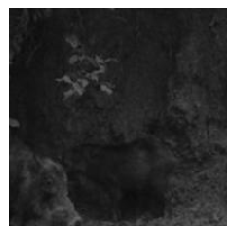

In [4]:
# Run this to test your train data loader
images, labels = next(iter(trainloader))
helper.imshow(images[0], normalize=False)

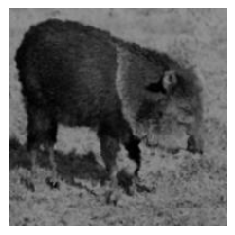

In [5]:
# Run this to test your test data loader
t_images, t_labels = next(iter(testloader))
helper.imshow(t_images[0], normalize=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

model

In [ ]:
fc = nn.Sequential(nn.Linear(2048, 1024),
                   nn.ReLU(),
                   nn.Dropout(0.2),
                   nn.Linear(1024, 512),
                   nn.ReLU(),
                   nn.Dropout(0.2),
                   nn.Linear(512, 256),
                   nn.ReLU(),
                   nn.Dropout(0.2),
                   nn.Linear(256, 2),
                   nn.LogSoftmax(dim=1))

model.fc = fc

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

In [ ]:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()
                    
                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                # print(ps, top_p, top_class, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/print_every:.3f}.. "
              f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {accuracy/len(testloader):.3f}")
        running_loss = 0

In [ ]:
torch.save(model.state_dict(), "./resnet50_2.pth")

In [6]:
loaded_model = models.resnet50(pretrained=False)
fc = nn.Sequential(nn.Linear(2048, 1024),
                   nn.ReLU(),
                   nn.Dropout(0.2),
                   nn.Linear(1024, 512),
                   nn.ReLU(),
                   nn.Dropout(0.2),
                   nn.Linear(512, 256),
                   nn.ReLU(),
                   nn.Dropout(0.2),
                   nn.Linear(256, 2),
                   nn.LogSoftmax(dim=1))

loaded_model.fc = fc
loaded_model.load_state_dict(torch.load("./resnet50_2.pth"))
loaded_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(loaded_model.fc.parameters(), lr=0.003)

loaded_model.to(device)


test_loss = 0
accuracy = 0
loaded_model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = loaded_model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()
                    
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        #print(top_class)
        equals = top_class == labels.view(*top_class.shape)
        # print(ps, top_p, top_class, labels)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
print(#f"Epoch {epoch+1}/{epochs}.. "
      #f"Train loss: {running_loss/print_every:.3f}.. "
      f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")


Test loss: 0.411.. Test accuracy: 0.819


In [ ]:
t_images, t_labels = next(iter(testloader))
helper.imshow(t_images[0], normalize=False)
# print(t_labels[0])

false_pos = []
false_neg = []
true_pos = []
for t_images, t_labels in testloader:
    logpred = loaded_model.forward(t_images)
    pred = torch.exp(logpred)
    top_p, top_class = pred.topk(1, dim=1)


    for i in range(len(top_class)):
        #print("HELLO")
#         print(top_class.shape, labels.shape)
#         print(t_labels.view(*top_class.shape), t_labels.view(*top_class.shape)[i])
        #print(top_class[i], t_labels.view(*top_class.shape)[i])
        if top_class[i] == 1 and t_labels.view(*top_class.shape)[i] == 0:
            false_pos.append(1)
        else:
            false_pos.append(0)
        if top_class[i] == 0 and t_labels.view(*top_class.shape)[i] == 1:
            false_neg.append(1)
        else:
            false_neg.append(0)
        if top_class[i] == 1 and t_labels.view(*top_class.shape)[i] == 1:
            true_pos.append(1)
        else:
            true_pos.append(0)

#         equals = top_class == t_labels.view(*top_class.shape)
print(sum(false_pos))
print(sum(false_neg))
print(sum(true_pos))
    # print(pred, top_p, top_class, labels)

In [ ]:
idx = false_pos.index(1)
idx

In [ ]:
images, labels = next(iter(testloader))
for i in range(len(images)):
    helper.imshow(images[i])
    print(labels[i])

In [ ]:
test = []
for images, labels in testloader:
    for image in images:
        test.append(image.numpy())

In [ ]:
helper.imshow(test[idx])